In [10]:
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, SAGEConv, GCN
from scipy.sparse import coo_matrix
from scipy.sparse import load_npz
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import MinMaxScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Scale input and output data
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()

class Net(nn.Module):
    def __init__(self, num_node_features, num_output_features, dropout_rate=0.5):
        super(Net, self).__init__()
        self.conv1 = GCN(num_node_features, 64)
        self.conv2 = GCN(64, 64)
        self.conv3 = GCN(64, num_output_features)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(64)
        self.bn3 = nn.BatchNorm1d(num_output_features)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x1 = self.conv1(x, edge_index)
        x1 = F.leaky_relu(x1)
        x1 = self.bn1(x1)
        x1 = self.dropout(x1)

        x2 = self.conv2(x1, edge_index)
        x2 = F.leaky_relu(x2)
        x2 = self.bn2(x2)
        x2 = self.dropout(x2)

        x3 = self.conv3(x2, edge_index)
        x3 = F.leaky_relu(x3)
        x3 = self.bn3(x3)
        x3 = self.dropout(x3)

        return x3


# Load your input and output data
input_data = np.load('../../WaveSuite/regularWave_U_data_0_to_131.npy')
output_data = np.load('../../WaveSuite/regularWave_nut_data_0_to_131.npy')
output_data = np.expand_dims(output_data, 2)
#Load adjacency matrix
adjacency_matrix = load_npz('../preprocessing/sparse_adjacency_matrix.npz')
# adjacency_matrix = torch.load('../preprocessing/wave_complete_edge_list.pt')
# edge_index = adjacency_matrix.long()

cuda


In [11]:
def scaler(x, xmin, xmax, min, max):
    x, xmin, xmax = np.array(x), np.array(xmin), np.array(xmax)

    # Identify where xmin equals xmax
    equal_mask = np.equal(xmin, xmax)

    # Calculate scale where xmin does not equal xmax
    scale = np.divide((max - min), (xmax - xmin), where=~equal_mask)

    # Apply the scaling formula where xmin does not equal xmax
    x_scaled = np.where(equal_mask, min, scale * (x - xmin) + min)

    return x_scaled

input_data = np.log(input_data + 1)
output_data = np.log(output_data + 1)

min_input = np.min(input_data, 0)
max_input = np.max(input_data, 0)
min_output = np.min(output_data, 0)
max_output = np.max(output_data, 0)
minimum = 0
maximum = 1

mean_input = np.nanmean(input_data, 0)
print(mean_input.shape)
std_input = np.nanstd(input_data)
mean_output = np.nanmean(output_data, 0)
std_output = np.nanstd(output_data)

scaled_input_data = (input_data - mean_input)/std_input
scaled_output_data = (output_data - mean_output)/std_output
# scaled_input_data = scaler(input_data, min_input, max_input, minimum, maximum)
# scaled_output_data = scaler(output_data, min_output, max_output, minimum, maximum)

# Prepare edge_index
rows, cols = adjacency_matrix.nonzero()
rows_torch = torch.tensor(rows, dtype=torch.long)
cols_torch = torch.tensor(cols, dtype=torch.long)
edge_index = torch.stack([rows_torch, cols_torch], dim=0)

# Define the dataset as a list of Data objects
all_data = []
for i in range(input_data.shape[0]):
    x = torch.tensor(scaled_input_data[i, :, :], dtype=torch.float).to(device)
    y = torch.tensor(scaled_output_data[i, :, :], dtype=torch.float).to(device)
    data = Data(x=x, y=y, edge_index=edge_index)
    all_data.append(data)

# Now we split our dataset into training and testing sets
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42)

# Creating DataLoaders for your train and test sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)


(311203, 3)


In [12]:
# Directory to save checkpoints
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Model
model = Net(
    num_node_features=input_data.shape[2],
    num_output_features=output_data.shape[2]
    ).to(device)

print(output_data.shape[2])

TypeError: BasicGNN.__init__() missing 1 required positional argument: 'num_layers'

In [4]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
# Training loop
model.train()
for epoch in range(5000):
    train_loss = 0.0
    test_loss = 0.0

    # Training
    model.train()
    for batch in train_loader:
        data = batch.to(device)
        optimizer.zero_grad()
        out = model(data)

        loss = F.mse_loss(out, data.y)  # MSE loss for regression
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.num_graphs

    # Testing
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            data = batch.to(device)
            out = model(data)
            loss = F.mse_loss(out, data.y)  # MSE loss for regression

            test_loss += loss.item() * data.num_graphs

    # Compute average loss
    train_loss /= len(train_loader.dataset)
    test_loss /= len(test_loader.dataset)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Train Loss: {train_loss}, Test Loss: {test_loss}")

        # Save a checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_{epoch}.pt')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
        }, checkpoint_path)



Epoch: 0, Train Loss: 2.1513624558081994, Test Loss: 0.19803835451602936
Epoch: 100, Train Loss: 1.904561813061054, Test Loss: 0.7749332785606384
Epoch: 200, Train Loss: 1.7574483889799852, Test Loss: 0.8055179119110107
Epoch: 300, Train Loss: 1.6238923256213849, Test Loss: 0.7683523297309875
Epoch: 400, Train Loss: 1.5006587597040029, Test Loss: 0.732743501663208
Epoch: 500, Train Loss: 1.3789992057360136, Test Loss: 0.694716215133667
Epoch: 600, Train Loss: 1.262972776706402, Test Loss: 0.6598792672157288
Epoch: 700, Train Loss: 1.1616897949805627, Test Loss: 0.6027335524559021
Epoch: 800, Train Loss: 1.0640461536554189, Test Loss: 0.5564873814582825
Epoch: 900, Train Loss: 0.9751280087691087, Test Loss: 0.5122822523117065
Epoch: 1000, Train Loss: 0.8858764721797063, Test Loss: 0.46699875593185425
Epoch: 1100, Train Loss: 0.8079276405847989, Test Loss: 0.43918123841285706
Epoch: 1200, Train Loss: 0.7330529919037452, Test Loss: 0.40088844299316406
Epoch: 1300, Train Loss: 0.6634745827

KeyboardInterrupt: 

In [8]:
y_pred = np.zeros((26, 311203, 1))
test_data_collect = np.zeros((26, 311203, 1))

for i in range(len(test_data)- 1):
    data = test_data[i].to(device)  # Move entire Data object to GPU
    y_pred[i, :, :] = model(data).cpu().detach().numpy()
    test_data_collect[i, :, :] = data.y.cpu().numpy()  # Move y back to CPU before converting to numpy
    
y_pred = np.squeeze(y_pred)
#y_pred = scaler_output.inverse_transform(y_pred)
np.save('./y_pred.npy', y_pred)

test_data_collect = np.squeeze(test_data_collect)
np.save('./test_data.npy', test_data_collect)
print('Saved!')

Saved!


(311203, 1)
torch.Size([311203, 1])


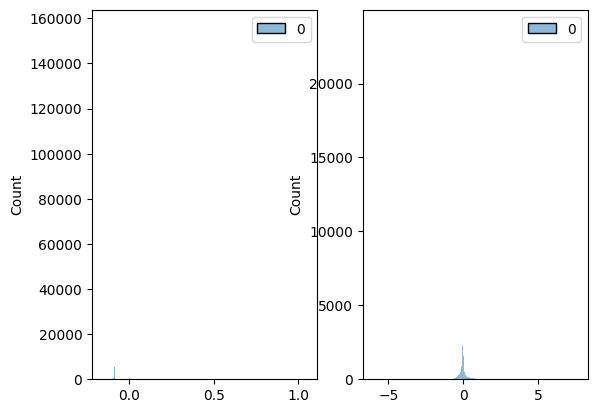

In [7]:
k = 20

data = test_data[k].to(device)  # Move entire Data object to GPU
predictions = model(data)
predictions = predictions.cpu()  # Move predictions to CPU
print(predictions.detach().numpy().shape)

import seaborn as sns
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
sns.histplot(predictions.detach().numpy())

plt.subplot(1,2,2)
sns.histplot(data.y.cpu().numpy())  # Move y back to CPU before converting to numpy

print(data.y.shape)
